# U.S. Elections 1976 - 2016

The election dataset was taken from the [MIT Election Lab](https://electionlab.mit.edu/data).

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read Data

In [2]:
# Get dataframe for election results
df = pd.read_csv("1976-2016-president.csv")
df.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes
0,1976,Alabama,AL,1,63,41,US President,"Carter, Jimmy",democrat,False,659170,1182850,20171015,NaN
1,1976,Alabama,AL,1,63,41,US President,"Ford, Gerald",republican,False,504070,1182850,20171015,NaN
2,1976,Alabama,AL,1,63,41,US President,"Maddox, Lester",american independent party,False,9198,1182850,20171015,NaN
3,1976,Alabama,AL,1,63,41,US President,"Bubar, Benjamin """"Ben""""",prohibition,False,6669,1182850,20171015,NaN
4,1976,Alabama,AL,1,63,41,US President,"Hall, Gus",communist party use,False,1954,1182850,20171015,NaN


In [3]:
# Get dataframe for electoral votes
elec = pd.read_csv("electoral_votes.csv")
elec.head()

,state,electoral_votes
0,Alabama,9
1,Alaska,3
2,Arizona,11
3,Arkansas,6
4,California,55


### Clean Data

Clean data I found that resulted in multiple rows (found this when visualizing):
* Arizona (2016)
* Maryland (2016)
* Minnesota (several years)

In [4]:
# Fix Maryland
df.drop(labels=[3542, 3543], axis=0, inplace=True)

# Fix Minnesota
df.loc[[2210, 2559, 3225],"party"] = "democrat"

# Fix Arizona
df.drop(labels=3414, axis=0, inplace=True)

I will structure the dataset by creating a spine (general state + year data), and then left joining democrat and republican results. In order to do so, I need to check that the spine is unique.

In [5]:
# Create spine
spine = df[["year", "state", "state_po", "totalvotes"]].drop_duplicates()
spine.columns = ["year", "state", "state_po", "total_votes"]

# Check for duplicates
spine.groupby(["year", "state", "state_po"]).count()[spine.groupby(["year", "state", "state_po"]).count().total_votes>1]

,,,total_votes
year,state,state_po,
2000,Nebraska,NE,2


In [6]:
# Check Nebraska 2000
spine[(spine.state=="Nebraska")&(spine.year==2000)]

,year,state,state_po,total_votes
2240,2000,Nebraska,NE,697019
2245,2000,Nebraska,NE,967019


In [7]:
# Manually dedupe Nebraska (bad data)
df.drop(labels=2245, axis=0, inplace=True)

Parse candidate names.

In [8]:
def parseName(name):
    """Parse candidate name."""
    if len(str(name).split(",")) == 2:
        return str(name).split(",")[1][1:] + " " + str(name).split(",")[0]
    else:
        return name
    
df["candidate_name"] = df.candidate.apply(lambda x: parseName(x))

In [9]:
candidates = df[df.party.isin(["democrat", "republican"])][["candidate_name", "year", "party"]].drop_duplicates()

In [11]:
# Manually clean
candidates.drop(labels=[2544, 3371], axis=0, inplace=True)

### Transform Data

In [12]:
# Recreate spine
spine = df[["year", "state", "state_po", "totalvotes"]].drop_duplicates()
spine.columns = ["year", "state", "state_po", "total_votes"]
spine = pd.merge(spine, elec, on="state")

# Count democrat popular votes
democrats = df[df.party == "democrat"][["year", "state", "candidatevotes"]]
democrats.columns = ["year", "state", "democrat_votes"]

# Count republican popular votes
republicans = df[df.party == "republican"][["year", "state", "candidatevotes"]]
republicans.columns = ["year", "state", "republican_votes"]

# Join onto spine + count other popular votes
df_transformed = pd.merge(pd.merge(spine, democrats, on=["year", "state"]), republicans, on=["year", "state"])
df_transformed["other_votes"] = df_transformed["total_votes"] - df_transformed["democrat_votes"] - df_transformed["republican_votes"]

# Get pecentage of popular votes by party
for party in ["democrat", "republican", "other"]:
    df_transformed[f"{party}_pct"] = df_transformed[f"{party}_votes"] / df_transformed["total_votes"]

# Get variance of popular vote percentage between democrat and republican
df_transformed["more_democrat"] = df_transformed["democrat_pct"] - df_transformed["republican_pct"]

# Get winning party
df_transformed["winning_party"] = df_transformed["more_democrat"].apply(lambda x: "democrat" if x > 0 else "republican")
columns = list(df_transformed.columns)

# Add candidate name to winning party
df_transformed = pd.merge(df_transformed, candidates, left_on=["year", "winning_party"], right_on=["year", "party"], how="left")

Mid-way through brainstorming the graphic, I wanted to explore different scenarios of how states determine the electoral votes. Most states use the winner-takes-all method, but Maine and Nebraska do not. 

Nebraska gave 1 electoral vote to Obama in 2008 and 4 to McCain. Main gave 3 votes to Clinton and 1 to Trump in 2016.

In [13]:
# Create columns for electoral vote based on party
df_transformed["democrat_electoral_votes"] = df_transformed.apply(lambda x: x.electoral_votes if x.winning_party == "democrat" else 0, axis=1)
df_transformed["republican_electoral_votes"] = df_transformed.apply(lambda x: x.electoral_votes if x.winning_party == "republican" else 0, axis=1)

# Override Nebraska 2008
df_transformed.loc[(df_transformed.state=="Nebraska")&(df_transformed.year==2008), "democrat_electoral_votes"]  = 1
df_transformed.loc[(df_transformed.state=="Nebraska")&(df_transformed.year==2008), "republican_electoral_votes"]  = 4

# Override Maine 2016
df_transformed.loc[(df_transformed.state=="Maine")&(df_transformed.year==2016), "democrat_electoral_votes"]  = 3
df_transformed.loc[(df_transformed.state=="Maine")&(df_transformed.year==2016), "republican_electoral_votes"]  = 1

In [14]:
# Export as csv
df_transformed.to_csv("election_results.csv", header=True, index=False)
df_transformed.head()

,year,state,state_po,total_votes,electoral_votes,democrat_votes,republican_votes,other_votes,democrat_pct,republican_pct,other_pct,more_democrat,winning_party,candidate_name,party,democrat_electoral_votes,republican_electoral_votes
0,1976,Alabama,AL,1182850,9,659170,504070,19610,0.557273,0.426149,0.016579,0.131124,democrat,Jimmy Carter,democrat,9,0
1,1980,Alabama,AL,1341929,9,636730,654192,51007,0.474489,0.487501,0.038010,-0.013013,republican,Ronald Reagan,republican,0,9
2,1984,Alabama,AL,1441713,9,551899,872849,16965,0.382808,0.605425,0.011767,-0.222617,republican,Ronald Reagan,republican,0,9
3,1988,Alabama,AL,1378476,9,549506,815576,13394,0.398633,0.591650,0.009717,-0.193018,republican,George H.W. Bush,republican,0,9
4,1992,Alabama,AL,1688060,9,690080,804283,193697,0.408801,0.476454,0.114745,-0.067653,republican,George H.W. Bush,republican,0,9


In [18]:
df_transformed[["year", "candidate_name"]].drop_duplicates().sort_values(by="year")

,year,candidate_name
0,1976,Jimmy Carter
11,1976,Gerald Ford
1,1980,Ronald Reagan
89,1980,Jimmy Carter
2,1984,Ronald Reagan
90,1984,Walter Mondale
91,1988,Michael Dukakis
3,1988,George H.W. Bush
4,1992,George H.W. Bush
37,1992,Bill Clinton


### Visualize Data

Initially I wanted to color code states based on their unwavering loyalty towards a certain party (e.g. CA would be blue because the state is strongly democrat). However, I learned that most states have actually voted Republican in the 1980s (was the Democrat candidate that bad?!). The visualization below shows a few always-republican states and almost no always-democrat states. It turns out that swing states should be based on some past few elections instead of all-time, and now I have to think of a new idea.

R - Alaska
D - District of Columbia
R - Idaho
R - Kansas
D - Minnesota
R - Nebraska
R - North Dakota
R - Oklahoma
R - South Dakota
R - Utah
R - Wyoming


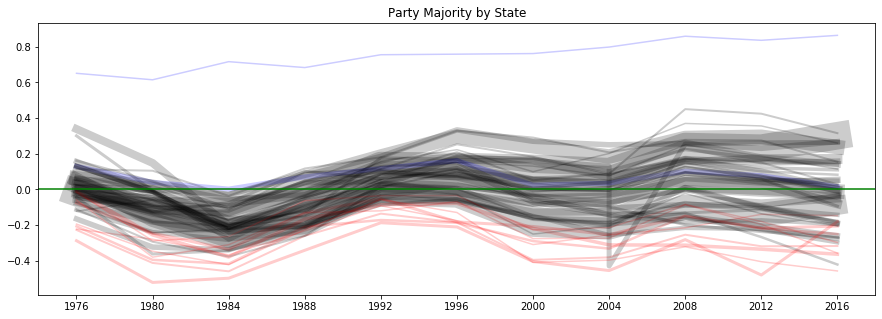

In [15]:
# Plot % Democrat over time

fig, ax = plt.subplots(figsize=[15,5])
ax.set_title("Party Majority by State")

for state in list(df_transformed.state.unique()):
    
    p = df_transformed[df_transformed.state == state].sort_values(by="year")
    
    # If state has more democrat votes every year then color it blue
    if p[p.more_democrat > 0].shape[0] == p.shape[0]:
        color = "b"
        print(f"D - {state}")
    # If state has more republican votes every year then color it red
    elif p[p.more_democrat < 0].shape[0] == p.shape[0]:
        color = "r"
        print(f"R - {state}")
    # Color black otherwise
    else:
        color = "k"
    
    linewidth = p.electoral_votes.unique()
    
    ax.plot(p.year, p.more_democrat, color=color, alpha=0.2, linewidth=linewidth/2)
    
ax.axhline(y=0, color="g")
ax.set_xticks(p.year)
plt.show()

Voter participation usually increases each year but at different rates. I really wanted to get 2020 election data, since the voter participation increased significantly, but the data isn't out yet.

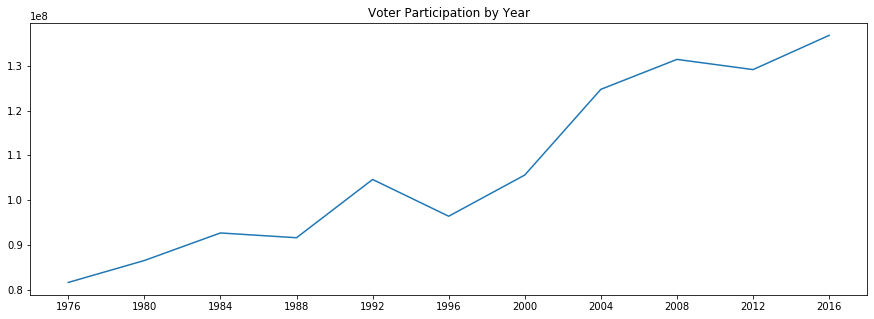

In [17]:
# Plot voter participation by year

fig, ax = plt.subplots(figsize=[15,5])
ax.set_title("Voter Participation by Year")

p = df_transformed.groupby("year").sum().reset_index().sort_values(by="year")
ax.set_xticks(p.year)
ax.plot(p.year, p.total_votes)
plt.show()

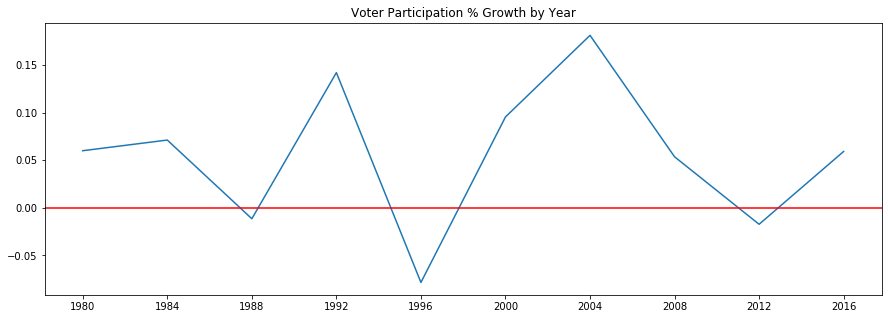

In [18]:
# Plot growth of voter participation by year

fig, ax = plt.subplots(figsize=[15,5])
ax.set_title("Voter Participation % Growth by Year")

p = df_transformed.groupby("year").sum().reset_index().sort_values(by="year")
p["total_votes_prev"] = p.total_votes.shift()
p["growth"] = (p.total_votes - p.total_votes_prev) / p.total_votes_prev

ax.set_xticks(p.year)
ax.plot(p.year, p.growth)
ax.axhline(y=0, color="red")
plt.show()

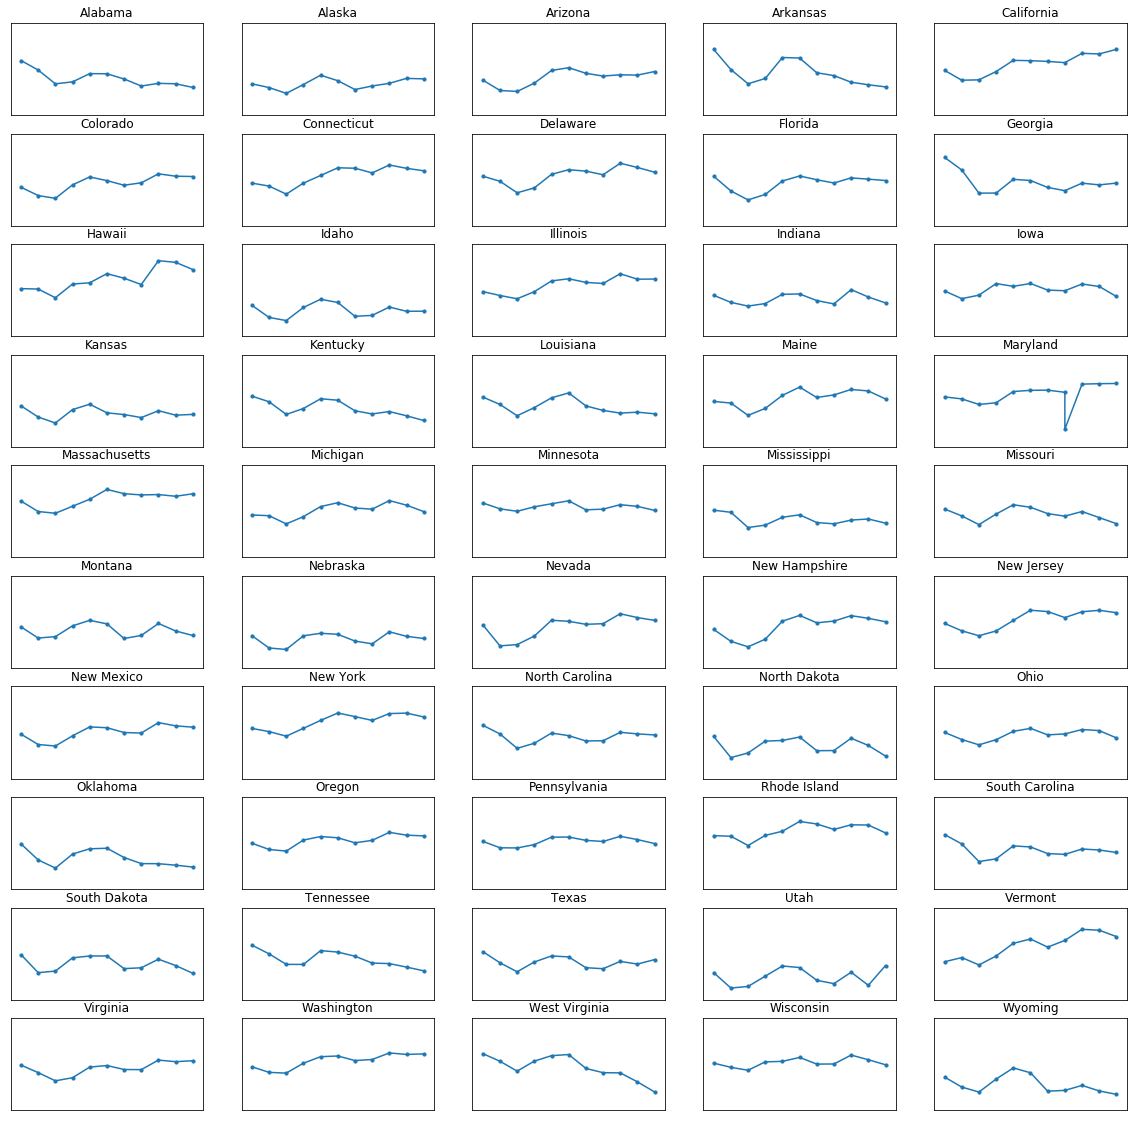

In [19]:
# Plot all states individually

fig, axes = plt.subplots(10, 5, figsize=[20, 20])
axes = axes.flatten()

states = list(df_transformed[df_transformed.state_po != "DC"].state.unique())

for i, state in enumerate(states):
    
    ax = axes[i]
    p = df_transformed[df_transformed.state == state]
    
    ax.plot(p.year, p.more_democrat)
    ax.scatter(p.year, p.more_democrat, s=10)
    ax.set_title(state)

    ax.set_ylim([-.7, .7])
    ax.set_xticks([])
    ax.set_yticks([])

In [23]:
df[(df.state == "Maryland")]

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes,candidate_name
122,1976,Maryland,MD,24,52,52,US President,"Carter, Jimmy",democrat,False,759612,1432273,20171015,NaN,Jimmy Carter
123,1976,Maryland,MD,24,52,52,US President,"Ford, Gerald",republican,False,672661,1432273,20171015,NaN,Gerald Ford
475,1980,Maryland,MD,24,52,52,US President,"Carter, Jimmy",democrat,False,726161,1540496,20171015,NaN,Jimmy Carter
476,1980,Maryland,MD,24,52,52,US President,"Reagan, Ronald",republican,False,680606,1540496,20171015,NaN,Ronald Reagan
477,1980,Maryland,MD,24,52,52,US President,"Anderson, John B.",independent,False,119537,1540496,20171015,NaN,John B. Anderson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3537,2016,Maryland,MD,24,52,52,US President,"Johnson, Gary",libertarian,False,79605,2781446,20171015,NaN,Gary Johnson
3538,2016,Maryland,MD,24,52,52,US President,"Stein, Jill",green,False,35945,2781446,20171015,NaN,Jill Stein
3539,2016,Maryland,MD,24,52,52,US President,NaN,NaN,True,33263,2781446,20171015,NaN,NaN
3540,2016,Maryland,MD,24,52,52,US President,Other,NaN,True,10921,2781446,20171015,NaN,Other


In [22]:
df_transformed[df_transformed.state == "Maryland"]

,year,state,state_po,total_votes,electoral_votes,democrat_votes,republican_votes,other_votes,democrat_pct,republican_pct,other_pct,more_democrat,winning_party,candidate_name,party,democrat_electoral_votes,republican_electoral_votes
220,1976,Maryland,MD,1432273,10,759612,672661,0,0.530354,0.469646,0.000000,0.060708,democrat,Jimmy Carter,democrat,10,0
221,1980,Maryland,MD,1540496,10,726161,680606,133729,0.471381,0.441810,0.086809,0.029572,democrat,Jimmy Carter,democrat,10,0
222,1984,Maryland,MD,1675873,10,787935,879918,8020,0.470164,0.525051,0.004786,-0.054887,republican,Ronald Reagan,republican,0,10
223,1988,Maryland,MD,1714358,10,826304,876167,11887,0.481990,0.511076,0.006934,-0.029086,republican,George H.W. Bush,republican,0,10
224,1992,Maryland,MD,1984580,10,988571,707094,288915,0.498126,0.356294,0.145580,0.141832,democrat,Bill Clinton,democrat,10,0
225,1996,Maryland,MD,1780870,10,966207,681530,133133,0.542548,0.382695,0.074757,0.159853,democrat,Bill Clinton,democrat,10,0
226,2000,Maryland,MD,2025212,10,1144008,813827,67377,0.564883,0.401848,0.033269,0.163035,democrat,Al Gore,democrat,10,0
227,2004,Maryland,MD,2384238,10,1334493,1024703,25042,0.559715,0.429782,0.010503,0.129932,democrat,John Kerry,democrat,10,0
228,2004,Maryland,MD,2384238,10,7,1024703,1359528,0.000003,0.429782,0.570215,-0.429779,republican,George W. Bush,republican,0,10
229,2008,Maryland,MD,2631596,10,1629467,959862,42267,0.619193,0.364745,0.016061,0.254448,democrat,Barack H. Obama,democrat,10,0


### What's the best way to detect a swing state?

Swing states have a population of voters that wave between democrat and republican, so they become the most important states to influence for elections.

There's no exact formula for defining a swing states, but these patterns are observed:
* Democrat and Republican voter percentage are pretty equal.
* State becomes less one-sided (i.e. becomes more equal) over the years. A possible explanation is the new voter generation that increase the number of democrat participation.
* Electoral votes switch between democrat and republican over the last few elections.

#### For 2016 election...

The 2016 swing states are Arizona, Florida, Georgia, New Hampshire, North Carolina, Maine 2nd Congressional District, Colorado, Nevada, Pennsylvania, Virginia, Wisconsin, Iowa, and Ohio.

The chart below shows that there are 14 states within 10% of party variance. Only 4 states have party variance within 5% in 2012.

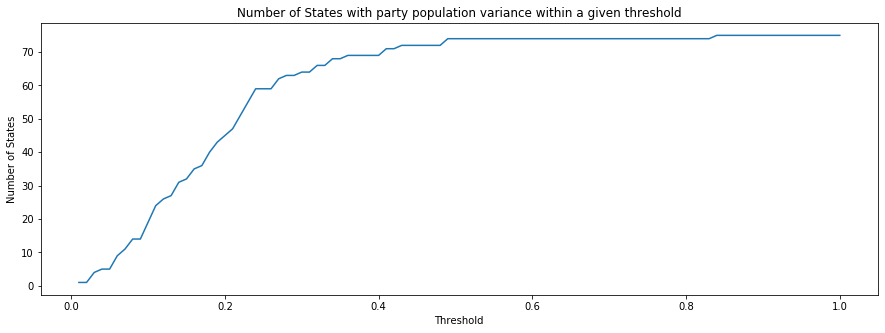

   threshold  number_states
0       0.01              1
1       0.02              1
2       0.03              4
3       0.04              5
4       0.05              5
5       0.06              9
6       0.07             11
7       0.08             14
8       0.09             14
9       0.10             19


In [17]:
# Plot variance by number of states
# The steeper the line, the "less effort" it takes to sway more states

df = df_transformed[df_transformed.year == 2012]

def number_states_within_threshold(threshold):
    """Returns number of states with a variance within the given threshold"""
    return df[abs(df.more_democrat) < threshold].shape[0]


thresholds = pd.DataFrame(np.arange(.01, 1.01, .01), columns=["threshold"])
thresholds["number_states"] = thresholds["threshold"].apply(lambda x: number_states_within_threshold(x))

fig, ax = plt.subplots(figsize=[15, 5])
ax.set_title("Number of States with party population variance within a given threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("Number of States")
ax.plot(thresholds.threshold, thresholds.number_states)
plt.show()

print(thresholds.head(10))

Increase Alaska 0.02 -0.26
Increase Indiana 0.01 -0.12
Decrease Massachusetts -0.02 0.31
Decrease Minnesota -0.01 0.09
Increase Nebraska 0.01 -0.25
Increase New Hampshire 0.0 0.04
Decrease New Jersey -0.0 0.13
Increase North Carolina 0.02 -0.1
Increase Ohio 0.0 0.01
Decrease Pennsylvania -0.0 0.06
Decrease Rhode Island -0.01 0.29
Increase Virginia 0.03 -0.07


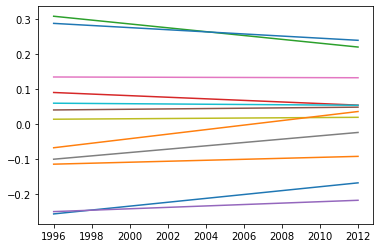

In [18]:
# Plot swing states movement between 1996 and 2012

df = df_transformed[(df_transformed.year >= 1996)&(df_transformed.year < 2016)]
data = {}
fig, ax = plt.subplots()
for state in list(df.state.unique()):
    p = df[df.state == state]
    m, b = np.polyfit(p.year, p.more_democrat, 1)
    x = np.linspace(1996,2012,5)
    y = m*x + b
    if (m * 2012 + b < .05 and m > 0):
        print("Increase", state, round(m*4, 2), round(m * 1996 + b, 2))
        ax.plot(x, y)
    elif (m * 2012 + b > .05 and m < 0):
        print("Decrease", state, round(m*4, 2), round(m * 1996 + b, 2))
        ax.plot(x, y)

In [19]:
# Rename dataframe to make things easier
df = df_transformed

# Get states where voter percentage is roughly equal 
print("Voter variance within 0-5%:", list(df[(df.year == 2012)&(abs(df.more_democrat)<.05)].state)) # These are all swing states
print("Voter variance within 5-8%:", list(df[(df.year == 2012)&(abs(df.more_democrat)>=.05)&(abs(df.more_democrat)<.08)].state)) # These are also all swing states, all we need is Arizona
print("Voter variance within 8-10%:", list(df[(df.year == 2012)&(abs(df.more_democrat)>=.08)&(abs(df.more_democrat)<.1)].state)) # Only Arizona is a swing state according to my source, but Michigan was a swing state in 2020

# Get states that swing between parties over the last few elections (over last 20 years, which is a full generation)
p = df[(df.year >= 2008)&(df.year < 2016)][["state", "winning_party"]].drop_duplicates().groupby("state").count().reset_index()
print("Elected both democrat and republican candidate in past 8 years:", list(p[p.winning_party>1].state))
p = df[(df.year >= 2004)&(df.year < 2016)][["state", "winning_party"]].drop_duplicates().groupby("state").count().reset_index()
print("Elected both democrat and republican candidate in past 12 years:", list(p[p.winning_party>1].state))
p = df[(df.year >= 1996)&(df.year < 2016)][["state", "winning_party"]].drop_duplicates().groupby("state").count().reset_index()
print("Elected both democrat and republican candidate in past 20 years:", list(p[p.winning_party>1].state))

Voter variance within 0-5%: ['Florida', 'North Carolina', 'North Carolina', 'Ohio', 'Virginia']
Voter variance within 5-8%: ['Colorado', 'Georgia', 'Georgia', 'Iowa', 'Minnesota', 'Nevada', 'New Hampshire', 'Pennsylvania', 'Wisconsin']
Voter variance within 8-10%: ['Arizona', 'Arizona', 'Michigan', 'Missouri', 'Missouri']
Elected both democrat and republican candidate in past 8 years: ['Indiana', 'North Carolina']
Elected both democrat and republican candidate in past 12 years: ['Colorado', 'Florida', 'Indiana', 'Iowa', 'Maryland', 'Nevada', 'New Mexico', 'North Carolina', 'Ohio', 'Virginia']
Elected both democrat and republican candidate in past 20 years: ['Arizona', 'Arkansas', 'Colorado', 'Florida', 'Indiana', 'Iowa', 'Kentucky', 'Louisiana', 'Maryland', 'Missouri', 'Nevada', 'New Hampshire', 'New Mexico', 'North Carolina', 'Ohio', 'Tennessee', 'Virginia', 'West Virginia']


#### For 2020 election...

In [20]:
# Rename dataframe to make things easier
df = df_transformed

# Get states where voter percentage is roughly equal 
print("Voter variance within 0-5%:", list(df[(df.year == 2016)&(abs(df.more_democrat)<.05)].state)) 
print("Voter variance within 5-8%:", list(df[(df.year == 2016)&(abs(df.more_democrat)>=.05)&(abs(df.more_democrat)<.08)].state)) 
print("Voter variance within 8-10%:", list(df[(df.year == 2016)&(abs(df.more_democrat)>=.08)&(abs(df.more_democrat)<.1)].state)) 

# Get states that swing between parties over the last few elections (over last 20 years, which is a full generation)
p = df[df.year >= 2012][["state", "winning_party"]].drop_duplicates().groupby("state").count().reset_index()
print("Elected both democrat and republican candidate in past 8 years:", list(p[p.winning_party>1].state))
p = df[df.year >= 2008][["state", "winning_party"]].drop_duplicates().groupby("state").count().reset_index()
print("Elected both democrat and republican candidate in past 12 years:", list(p[p.winning_party>1].state))

Voter variance within 0-5%: ['Arizona', 'Colorado', 'Florida', 'Maine', 'Michigan', 'Minnesota', 'Nevada', 'New Hampshire', 'North Carolina', 'Pennsylvania', 'Wisconsin']
Voter variance within 5-8%: ['Georgia', 'Virginia']
Voter variance within 8-10%: ['Iowa', 'New Mexico', 'Ohio', 'Texas']
Elected both democrat and republican candidate in past 8 years: ['Florida', 'Iowa', 'Michigan', 'Ohio', 'Pennsylvania', 'Wisconsin']
Elected both democrat and republican candidate in past 12 years: ['Florida', 'Indiana', 'Iowa', 'Michigan', 'North Carolina', 'Ohio', 'Pennsylvania', 'Wisconsin']


Increase Alaska 0.03 -0.19
Increase Arizona 0.02 -0.1
Decrease Colorado -0.02 0.08
Decrease Connecticut -0.04 0.22
Decrease Delaware -0.07 0.25
Increase Georgia 0.0 -0.07
Decrease Hawaii -0.07 0.46
Decrease Illinois -0.04 0.24
Decrease Iowa -0.09 0.11
Decrease Maine -0.07 0.19
Decrease Michigan -0.08 0.17
Decrease Minnesota -0.04 0.11
Decrease Nevada -0.05 0.12
Decrease New Hampshire -0.05 0.1
Decrease New Jersey -0.01 0.17
Decrease New Mexico -0.03 0.15
Decrease New York -0.03 0.3
Decrease Ohio -0.06 0.06
Decrease Oregon -0.03 0.16
Decrease Pennsylvania -0.06 0.11
Decrease Rhode Island -0.06 0.3
Increase Texas 0.01 -0.14
Increase Utah 0.05 -0.41
Decrease Vermont -0.06 0.38
Decrease Virginia -0.0 0.06
Decrease Washington -0.01 0.17
Decrease Wisconsin -0.07 0.14


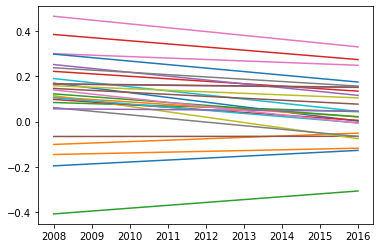

In [21]:
# Plot swing states movement between 2000 and 2016

starting_year = 2008
df = df_transformed[df_transformed.year >= starting_year]
data = {}
fig, ax = plt.subplots()
for state in list(df.state.unique()):
    p = df[df.state == state]
    m, b = np.polyfit(p.year, p.more_democrat, 1)
    x = np.linspace(starting_year,2016,5)
    y = m*x + b
    if (m * starting_year + b < .05 and m > 0):
        print("Increase", state, round(m*4, 2), round(m * starting_year + b, 2))
        ax.plot(x, y)
    elif (m * starting_year + b > .05 and m < 0):
        print("Decrease", state, round(m*4, 2), round(m * starting_year + b, 2))
        ax.plot(x, y)

Voter variance within 8% seems like the easiest indicator of a swing state.